In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

In [2]:
(images,labels),(_,_)=tf.keras.datasets.mnist.load_data()

In [3]:
images.shape
labels.shape

(60000,)

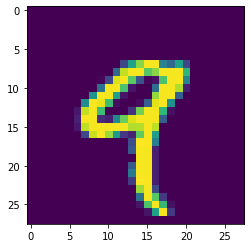

In [4]:
plt.imshow(images[4])

In [5]:
labels[:5]#索引为4的标签为9，与上图中数字相对应

array([5, 0, 4, 1, 9], dtype=uint8)

In [6]:
images[4] #图片中的像素是从0-255，因此要进行归一化

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  

In [7]:
images = images/127.5-1  #由于采用的是arctan函数来激活，所以将0-255映射到（-1，1）之间

In [8]:
images = np.expand_dims(images,-1)#扩展维度？？？

In [9]:
images.shape

(60000, 28, 28, 1)

In [10]:
dataset = tf.data.Dataset.from_tensor_slices((images,labels))

In [11]:
dataset                    #(28,28,1)为图像，（）为label

<TensorSliceDataset shapes: ((28, 28, 1), ()), types: (tf.float64, tf.uint8)>

In [12]:
batch_size = 256     #batch_size为一次训练所需的样本数
noise_dim  = 50

In [13]:
dataset = dataset.shuffle(60000).batch(batch_size)
#在所有60000个数据中每取出batch_size个数据打乱

以上为数据预处理

In [14]:
def generate():
    seed = layers.Input(shape = ((noise_dim)))
    label = layers.Input(shape = (()))#输入为一个数据，用一个空数组来表示
    
    x = layers.Embedding(10,50,input_length = 1)(label) 
    #输入长度为10,将label映射成了长度为50的向量，因为noise长度为50
    x = layers.Flatten()(x)
    x = layers.concatenate([seed,x])
    #将noise和label合并
    x = layers.Dense(3*3*128,use_bias = False)(x)#添加一层全连接层？？？
    x = layers.Reshape((3,3,128))(x)#初始图像大小为3*3*28，最后要将这个图像反卷积成28*28*1
    x = layers.BatchNormalization()(x) #归一化
    x = layers.ReLU()(x)#使用relu来激活x
    
    x = layers.Conv2DTranspose(64,(3,3),strides = (2,2),use_bias = False)(x)
    #使用64个卷积核，每个卷积核大小为3*3,因为要上采样到原来的两倍，所以步长为2
    x = layers.BatchNormalization()(x) 
    x = layers.ReLU()(x)
    #(7,7,64)
    x = layers.Conv2DTranspose(32,(3,3),strides = (2,2),padding = 'same',use_bias = False)(x)
    x = layers.BatchNormalization()(x) 
    x = layers.ReLU()(x)
    #(14,14,32)
    x = layers.Conv2DTranspose(1,(3,3),strides = (2,2),padding = 'same',use_bias = False)(x)
    x = layers.Activation('tanh')(x)
    #(28,28,1)
    model = tf.keras.Model(inputs = [seed,label],outputs = x)
    
    return model

In [15]:
gen = generate()

In [16]:
def discriminator():
    image = layers.Input(shape = (28,28,1))
    label = layers.Input(shape = (()))
    
    x = layers.Embedding(10,28*28,input_length = 1)(label)#???不太懂
    x = layers.Reshape((28,28,1))(x)
    x = layers.concatenate([x,image])#将label和image合并
    
    x = layers.Conv2D(32,(3,3),strides=(2,2),padding="same",use_bias = False)(x)
    x = layers.BatchNormalization()(x) 
    x = layers.LeakyReLU()(x)
    x = layers.Dropout(0.5)(x)#随机让一般的神经网络停止工作，提高网络的泛化能力
    #第一层卷积
    
    x = layers.Conv2D(64,(3,3),strides=(2,2),padding="same",use_bias = False)(x)
    x = layers.BatchNormalization()(x) 
    x = layers.LeakyReLU()(x)
    x = layers.Dropout(0.5)(x)
    
    x = layers.Conv2D(128,(3,3),strides=(2,2),padding="same",use_bias = False)(x)
    x = layers.BatchNormalization()(x) 
    x = layers.LeakyReLU()(x)
    x = layers.Dropout(0.5)(x)
    
    x = layers.Flatten()(x)
    
    out = layers.Dense(1)(x)#判断这个函数是真还是假,未激活的一个数值
    
    model = tf.keras.Model(inputs = [image,label],outputs = out)
    
    return model

In [17]:
disc = discriminator()

In [18]:
bce = tf.keras.losses.BinaryCrossentropy(from_logits = True)#交叉熵，这个概念再看看

bce()#这里可以shift+tab看看输入输出

In [19]:
def disc_loss(real_out,fake_out):#真实值输出1,计算判别器损失,希望生成图像都被判别为0
    real_loss = bce(tf.ones_like(real_out),real_out) #这里函数没太懂
    fake_loss = bce(tf.zeros_like(fake_out),fake_out) 
    #这两行就是将真实值与1计算交叉熵得到损失loss，将虚假值与0计算交叉熵得到loss
    return real_loss+fake_loss

In [20]:
def gen_loss(fake_out):#希望生成图像都被判别为1
    return bce(tf.ones_like(fake_out),fake_out)

以上为生成器和判别器的损失函数

In [21]:
gen_opt = tf.keras.optimizers.Adam(1e-5)#对以上loss利用adam函数进行优化
disc_opt = tf.keras.optimizers.Adam(1e-5)

In [22]:
@tf.function #函数装饰器的资料看下
def train_step(image,label):#批次训练函数
    size = label.shape[0]#定义一个批次为label数，也就是60000张
    noise = tf.random.normal([size,noise_dim])
    
    with tf.GradientTape() as gen_tape,tf.GradientTape() as disc_tape:
    #上下文管理器，记录每次训练过程
        gen_imgs = gen((noise,label),training = True)#将噪声和label放入生成器生成假的图像
        fake_out = disc((gen_imgs,label),training = True)#用判别器判断生成的图像是真是假，得到假图像的输出
        real_out = disc((image,label),training = True)#将真实图像放入判别器中，得到一个输出
        
        d_loss = disc_loss(real_out,fake_out)
        g_loss = gen_loss(fake_out)
        #计算损失函数
    
    gen_grad = gen_tape.gradient(g_loss,gen.trainable_variables)#计算生成器和对应变量的梯度
    disc_grad = disc_tape.gradient(d_loss,disc.trainable_variables)
    
    gen_opt.apply_gradients(zip(gen_grad,gen.trainable_variables))
    #根据得到的梯度来优化varibles
    disc_opt.apply_gradients(zip(disc_grad,disc.trainable_variables))

以上为批次训练函数

In [23]:
def plot_gen_image(model,noise,label,epoch_num):
    print('Epoch:',epoch_num)
    gen_image = model((noise,label),training = False)#得到的是一个批次的图像
    gen_image = tf.squeeze(gen_image)#(28,28,1)——>(28,28)降维
    fig = plt.figure(figsize=(10,1))#创建一个画布
    for i in range(gen_image.shape[0]):#shape的第一个维度就是image的个数
        plt.subplot(1,10,i+1)
        plt.imshow((gen_image[i,:,:]+1)/2)#第i张图片,将（-1，1）映射到（0，1）
        plt.axis('off')#关坐标
        
    plt.show()

以上为画图函数

In [24]:
num = 10
noise_seed = tf.random.normal([num,noise_dim])
label_seed = np.random.randint(0,10,size = (num,1))
print(label_seed.T)#随机生成的10个数字

[[1 6 5 2 3 0 0 4 6 4]]


In [25]:
def train(dataset,epochs):
    for epoch in range(epochs):#批次循环
        for image_batch,label_batch in dataset:
            train_step(image_batch,label_batch)#接收每一个batch的数据来训练
        if epoch % 10 == 0:
            plot_gen_image(gen,noise_seed,label_seed,epoch)#绘图
    plot_gen_image(gen,noise_seed,label_seed,epoch)       

In [26]:
Epoches = 200

Epoch: 0


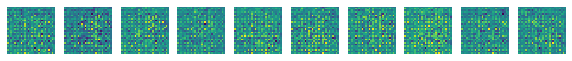

Epoch: 10


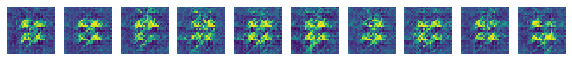

Epoch: 20


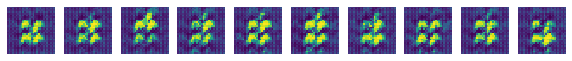

Epoch: 30


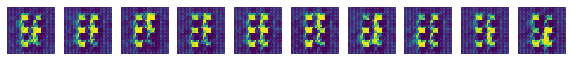

Epoch: 40


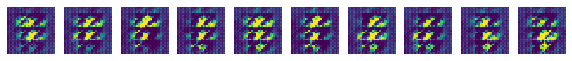

Epoch: 50


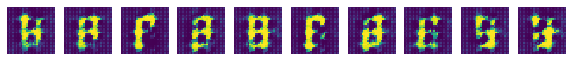

Epoch: 60


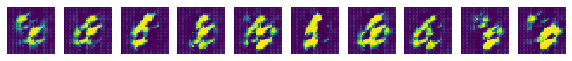

Epoch: 70


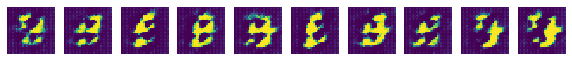

Epoch: 80


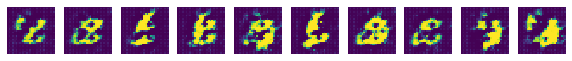

Epoch: 90


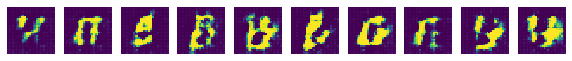

Epoch: 100


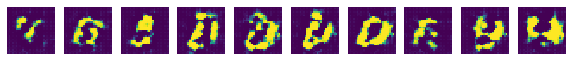

Epoch: 110


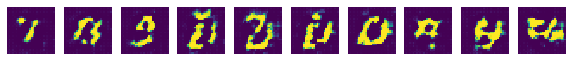

Epoch: 120


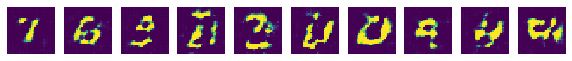

Epoch: 130


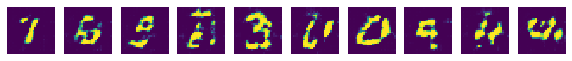

Epoch: 140


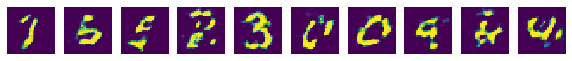

Epoch: 150


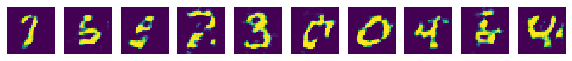

Epoch: 160


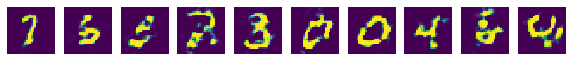

Epoch: 170


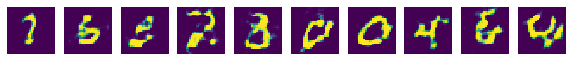

Epoch: 180


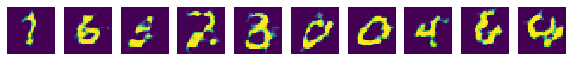

Epoch: 190


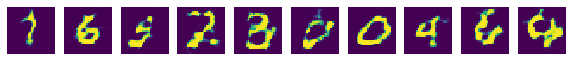

Epoch: 199


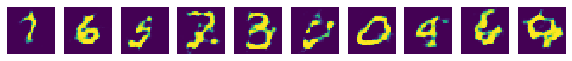

In [27]:
train(dataset,Epoches)